# Deep Learning Models for stock prediction - LSTM

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Import data

The data was downloaded from Bloomberg on:
* Exchange rate of Vietnam with its major trading partners: the China and the US
* Precious metal spot price and future price: Gold, Silver, Palladium, Platinum
* Global Stock Indices: Hang Seng Index, Nasdaq 100, Nasdaq Composite, Nikkei 225, SP500, DOJI, Shanghai Shenzhen CSI3000, Shanghai Shenzhen Composite and Singapore Stock Index
* Volatility stock index: VIX Index

The data will be imported from previous EDA session, which has been cleaned and included only important features: Palladium, SP500 Index and SHSZ CSI300 Index

In [2]:
# Import data
data = pd.read_csv('data.csv')

# Transfer date column to date time
import datetime
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')

# Turn date into index
data.set_index('Date', inplace = True)

# Deep Learning model - LSTM

We will build two versions of the model
- Univariate LSTM prediction (using the target VN-Index price only)
- Multivariate LSTM prediction (combine with global stock indices and commodity price)

## Proprocessing data

In [3]:
# Define only target variable dataset
data_uni = data[['index_vni']]

In [4]:
# Import necessary libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Activation, Input, Dropout
import tensorflow as tf
import keras

In [5]:
# Extract the target values
target = data_uni.values

# Normalize the target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target.reshape(-1,1))

In [6]:
# Define train and validation data
train_time = int(round(len(target_scaled) * 0.8))

train_data = target_scaled[:train_time]
test_data = target_scaled[train_time:]

# Check length of each dataset
print(train_data.shape)
print(test_data.shape)

(3340, 1)
(835, 1)


In [70]:
# Generate data for training set
past_days = 30
predict_days = 7

X_train = []
y_train = []

for i in range(past_days,len(train_data) - (past_days + predict_days) + 1):
    X_train.append(train_data[i - past_days : i])
    y_train.append(train_data[i : i+ predict_days])

# Turn sequences into Numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [73]:
# Generate data for validation set
past_days = 30
predict_days = 7

X_test = []
y_test = []

for i in range(past_days,len(test_data) - past_days):
    X_test.append(test_data[i - past_days : i])
    y_test.append(test_data[i : i + predict_days])

# Turn sequences into Numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)

In [74]:
# Check the shape of training and validation set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3274, 30, 1)
(775, 30, 1)
(3274, 7, 1)
(775, 7, 1)


## Building model

In [88]:
keras.backend.clear_session()

In [89]:
# Build the model
model = Sequential([
    LSTM(64,activation = 'relu',return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation = 'relu'),
    Dense(1)
])

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss = 'mean_absolute_error', optimizer= optimizer)

# Summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
# Train the model
history = model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_data= (X_test, y_test))

Epoch 1/30
52/52 [==============================] - 5s 40ms/step - loss: 0.0780 - val_loss: 0.0657
Epoch 2/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0184 - val_loss: 0.0422
Epoch 3/30
52/52 [==============================] - 2s 37ms/step - loss: 0.0168 - val_loss: 0.0336
Epoch 4/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0161 - val_loss: 0.0338
Epoch 5/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0156 - val_loss: 0.0297
Epoch 6/30
52/52 [==============================] - 2s 35ms/step - loss: 0.0151 - val_loss: 0.0260
Epoch 7/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0151 - val_loss: 0.0236
Epoch 8/30
52/52 [==============================] - 2s 35ms/step - loss: 0.0150 - val_loss: 0.0261
Epoch 9/30
52/52 [==============================] - 2s 34ms/step - loss: 0.0139 - val_loss: 0.0345
Epoch 10/30
52/52 [==============================] - 2s 38ms/step - loss: 0.0146 - val_loss: 0.0319
Epoch 11/

In [91]:
# Make predictions
predictions = model.predict(X_test)

# Refit scaler
prediction_copy = np.repeat(predictions, X_train.shape[1], axis = -1)

# Transform predictions back to original scale
predictions_scaled = scaler.inverse_transform(prediction_copy)[:,0]

25/25 [==============================] - 0s 8ms/step


In [92]:
# Set index for the predictions
index_test = actual = data_uni.iloc[-775:].index

# Put the index for prediction
predictions_scaled = pd.DataFrame(data = predictions_scaled, index = index_test)

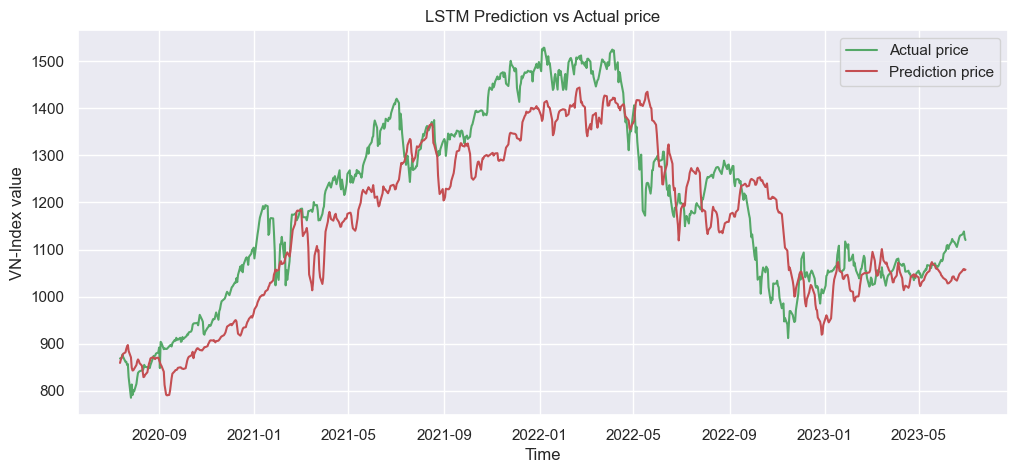

In [93]:
# Compare LSTM model with actual result
actual = data_uni.iloc[-775:]

# Visualize the data
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(actual, color = 'g', label = 'Actual price')
ax.plot(predictions_scaled, color = 'r', label = 'Prediction price')
ax.set_xlabel('Time')
ax.set_ylabel('VN-Index value')
ax.set_title('LSTM Prediction vs Actual price')
plt.legend()
plt.show()

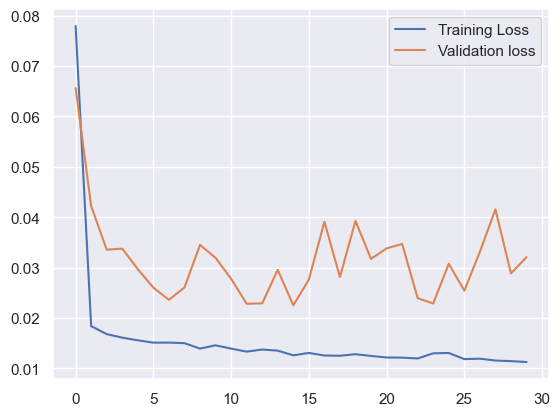

In [94]:
# Plot training and test lost
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [95]:
# Calculate MAE
predictions_scaled_values = predictions_scaled.values
actual_values = actual.values

In [96]:
# Define MAE and MSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Calculate mae
mae_lstm_uni = mae(actual_values, predictions_scaled_values)
mse_lstm_uni = mse(actual_values, predictions_scaled_values)

# Print out result
print(f"MAE: {mae_lstm_uni} \n"
      f"MSE: {mse_lstm_uni}")

MAE: 75.9953269720262 
MSE: 8427.384189357126


The univariate model seems to predict worse than normal Machine Learning - Linear Regression models. The training loss - graph shows us that the model is currently underfitting. Let's add the model again, but increase the units in a layer.

## Optimize the model

In [97]:
# Reset model
keras.backend.clear_session()

In [98]:
# Build the model
model = Sequential([
    LSTM(128,activation = 'relu',return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation = 'relu'),
    Dense(1)
])

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss = 'mean_absolute_error', optimizer= optimizer)

In [99]:
# Refit the model
history = model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_data= (X_test, y_test))

Epoch 1/30
52/52 [==============================] - 5s 49ms/step - loss: 0.0634 - val_loss: 0.0654
Epoch 2/30
52/52 [==============================] - 2s 44ms/step - loss: 0.0169 - val_loss: 0.0338
Epoch 3/30
52/52 [==============================] - 3s 50ms/step - loss: 0.0165 - val_loss: 0.0295
Epoch 4/30
52/52 [==============================] - 3s 58ms/step - loss: 0.0156 - val_loss: 0.0259
Epoch 5/30
52/52 [==============================] - 3s 58ms/step - loss: 0.0154 - val_loss: 0.0283
Epoch 6/30
52/52 [==============================] - 4s 72ms/step - loss: 0.0148 - val_loss: 0.0255
Epoch 7/30
52/52 [==============================] - 4s 78ms/step - loss: 0.0151 - val_loss: 0.0234
Epoch 8/30
52/52 [==============================] - 3s 53ms/step - loss: 0.0140 - val_loss: 0.0235
Epoch 9/30
52/52 [==============================] - 3s 61ms/step - loss: 0.0137 - val_loss: 0.0237
Epoch 10/30
52/52 [==============================] - 2s 48ms/step - loss: 0.0133 - val_loss: 0.0224
Epoch 11/

In [100]:
# Make predictions
predictions = model.predict(X_test)

# Transform predictions back to original scale
predictions_scaled = scaler.inverse_transform(predictions)

25/25 [==============================] - 1s 12ms/step


In [103]:
# Set index for the predictions
index_test = actual = data_uni.iloc[-775:].index

# Put the index for prediction
predictions_scaled = pd.DataFrame(data = predictions_scaled, index = index_test)

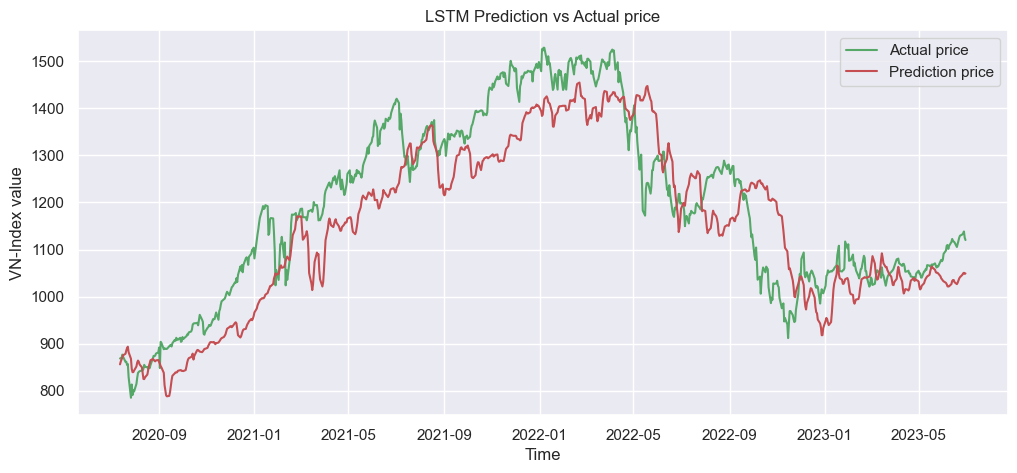

In [105]:
# Compare LSTM model with actual result
actual = data_uni.iloc[-775:]

# Visualize the data
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(actual, color = 'g', label = 'Actual price')
ax.plot(predictions_scaled, color = 'r', label = 'Prediction price')
ax.set_xlabel('Time')
ax.set_ylabel('VN-Index value')
ax.set_title('LSTM Prediction vs Actual price')
plt.legend()
plt.show()

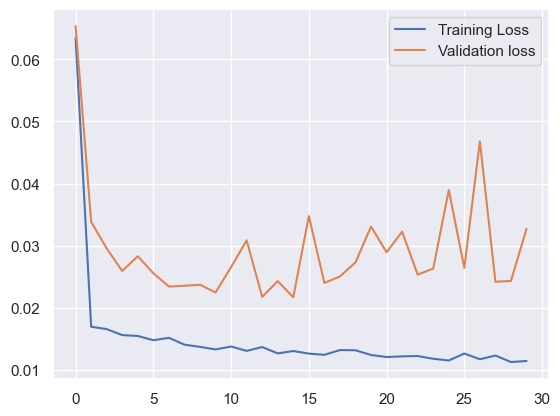

In [106]:
# Plot training and test lost
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [107]:
# Calculate MAE
predictions_scaled_values = predictions_scaled.values
actual_values = actual.values

In [108]:
# Define MAE and MSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Calculate mae
mae_lstm_uni = mae(actual_values, predictions_scaled_values)
mse_lstm_uni = mse(actual_values, predictions_scaled_values)

# Print out result
print(f"MAE: {mae_lstm_uni} \n"
      f"MSE: {mse_lstm_uni}")

MAE: 77.92826194241431 
MSE: 8716.28816581053


The model replicates quite well the pattern of the actual price. However, it seems like the prediction is just a delayed version of the actual prices. We will then add another layer to the model to see if we can fix the problem.

After putting more units to the model, we can see that the learning loss is fluctuated and cannot reached close to the training loss.